# Implementation of "Word embeddings are steers for language models"

## Setup

In [13]:
import datasets
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import pipeline

In [2]:
generator = pipeline('text-generation', model='EleutherAI/pythia-160m-deduped')

model = generator.model
tokenizer = generator.tokenizer

model_original_lm_head = model.embed_out

In [ ]:
class Steer(nn.Module):
  def __init__(self, lm_head: nn.Module, *, epsilon: float = 1e-3):
    super().__init__()

    self.epsilon = epsilon

    self.proj1 = nn.Linear(768, 1000, bias=False)
    self.proj2 = nn.Linear(1000, 768, bias=False)
    self.lm_head = lm_head

    with torch.no_grad():
      self.proj1.weight.normal_(std=1e-3)
      self.proj2.weight.normal_(std=1e-3)

  def set_steer_values(self, steer_values: torch.Tensor):
    self.steer_values = steer_values

  def forward(self, x: torch.Tensor):
    # x: (batch, seq, embedding)
    # self.steer_values: (seq)

    return self.lm_head(x + self.epsilon * self.proj2(self.proj1(x) * self.steer_values[:, None, None]))

for param in model.parameters():
  param.requires_grad = False

steer = Steer(model_original_lm_head)
model.embed_out = steer


## Training data loading

In [8]:
sentiment_items = list(datasets.load_dataset("SetFit/sst5")['train'])
sentiment_scores = torch.tensor([item['label'] for item in sentiment_items]) * 0.5 - 1.0 # -> [-1.0, 1.0]
sentiment_texts = [item['text'] for item in sentiment_items]

class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, texts, scores):
    self.texts = texts
    self.scores = scores

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, index):
    return self.texts[index], self.scores[index]

sentiment_dataset = SentimentDataset(sentiment_texts, sentiment_scores)


Repo card metadata block was not found. Setting CardData to empty.


## Training

In [ ]:
loader = DataLoader(sentiment_dataset, batch_size=64, shuffle=True)
tokenizer.pad_token = tokenizer.eos_token

optimizer = optim.Adam(model.parameters(), lr=1e-3)

current_loss = 0.0

for _ in range(10):
  for batch_index, (batch_texts, batch_scores) in enumerate(tqdm(loader)):
    optimizer.zero_grad()

    batch_tokenized = tokenizer(batch_texts, padding=True, return_tensors='pt')
    steer.set_steer_values(batch_scores)

    output = model(
      input_ids=batch_tokenized['input_ids'],
      attention_mask=batch_tokenized['attention_mask'],
      labels=batch_tokenized['input_ids'],
    )

    output.loss.backward()
    optimizer.step()

    batch_loss = output.loss.item() / len(batch_texts)
    current_loss += batch_loss

100%|██████████| 134/134 [09:37<00:00,  4.31s/it]


In [ ]:
steer.set_steer_values(torch.tensor([0.0]))
[generation[0]['generated_text'] for generation in generator(["My opinion on Paris is"] * 5, max_length=30, do_sample=True, pad_token_id=tokenizer.eos_token_id)]

['My opinion on Paris is one who thinks Paris has its place in our lives and is a place to make us feel good about our success. His opinion',
 'My opinion on Paris is so wrong I think that you were wrong. He can still tell the truth, he can even talk to the politicians who have',
 'My opinion on Paris is not only in\nthe right direction, but in the wrong direction. But\nin the right direction. We are heading across',
 'My opinion on Paris is that the new European economy will be characterized by a more diverse economy than other states of the world, which has been in trouble',
 'My opinion on Paris is a little\nyeah\nas it is. It is also a long way away from Paris\nif any of you have']

## Testing data loading

In [9]:
sentiment_pipeline = pipeline("sentiment-analysis", model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', top_k=None)

def get_sentiment(texts: list[str]):
  results = sentiment_pipeline(texts)
  return [item['score'] for result in results for item in result if item['label'] == 'POSITIVE']

print(get_sentiment(["I love you", "I hate you"]))

[0.9998656511306763, 0.0008870700839906931]


In [ ]:
# Checking that the training data is correctly classified
sentiment_values = get_sentiment(sentiment_texts)

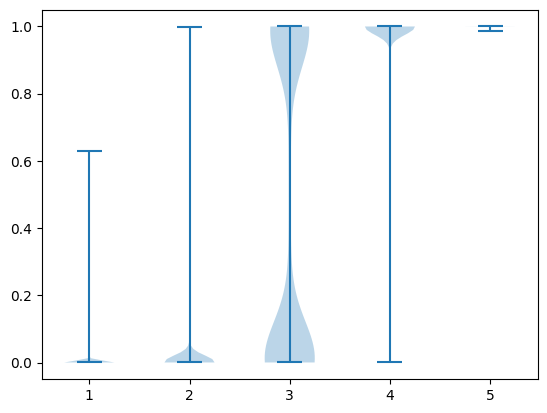

In [12]:
fig, ax = plt.subplots()

x = [np.array(sentiment_values)[sentiment_scores.numpy() == score] for score in [-1.0, -0.5, 0.0, 0.5, 1.0]]
ax.violinplot(x);

## Test

In [ ]:
repeat_count = 10
steer_values = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])

cities = ['Paris', 'London', 'New York', 'Tokyo', 'Berlin', 'Rome', 'Moscow', 'Beijing', 'Sydney', 'Cairo']
result = torch.zeros((len(steer_values), len(cities), repeat_count)) * torch.nan

for steer_value_index, steer_value in enumerate(steer_values):
  steer.set_steer_values(torch.tensor([steer_value]))

  for city_index, city in enumerate(tqdm(cities)):
    generated_texts = [generation[0]['generated_text'] for generation in generator([f'My opinion of {city} is'] * repeat_count, max_length=30, do_sample=True, pad_token_id=tokenizer.eos_token_id)]
    result[steer_value_index, city_index, :] = torch.tensor(get_sentiment(generated_texts))


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


Text(0, 0.5, 'Positivity')

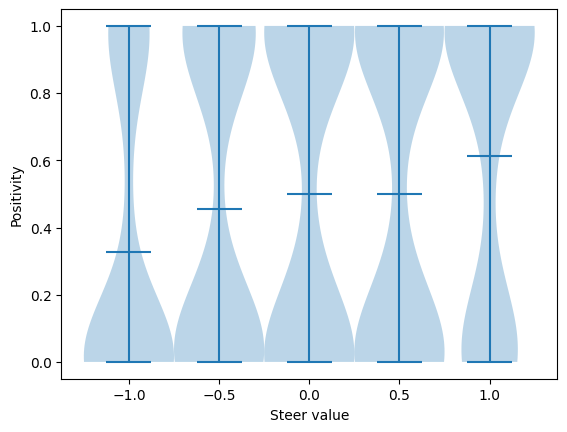

In [ ]:
fig, ax = plt.subplots()

ax.violinplot(result.numpy().reshape(len(steer_values), -1).T, steer_values.numpy(), showmeans=True)
ax.set_xlabel('Steer value')
ax.set_ylabel('Positivity')